#### Handwritten Text Recognition

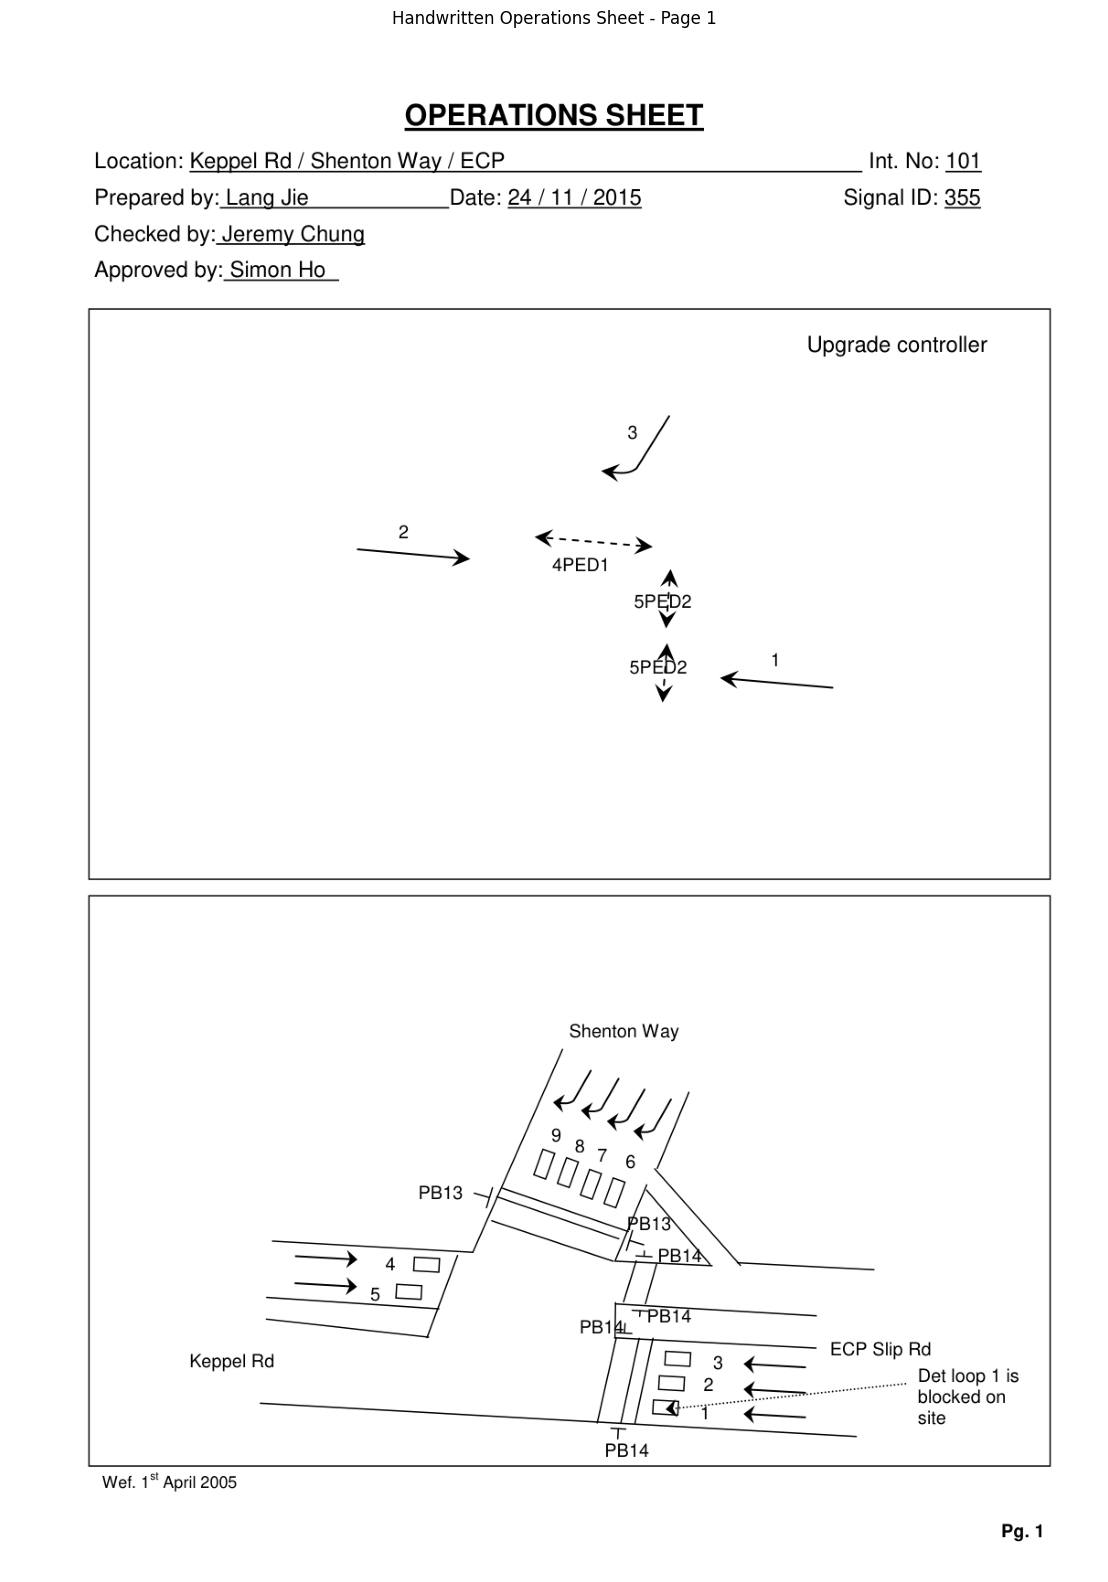

In [1]:
import os
import fitz  # PyMuPDF
import matplotlib.pyplot as plt
from PIL import Image
import io

# Define the path to the PDF file
pdf_path = r"../data/sample/raw/101_20151103-0583.pdf"

# Open the PDF file
pdf_document = fitz.open(pdf_path)

# Create a dictionary to store all pages as PIL Images
ops_sheet = {}

# Process each page in the PDF
for page_num in range(len(pdf_document)):
    # Get the page
    page = pdf_document[page_num]
    
    # Render the page as a pixmap (image)
    zoom = 2  # higher zoom for better resolution
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)
    
    # Convert pixmap to PIL Image
    img_data = pix.tobytes("png")
    img = Image.open(io.BytesIO(img_data))
    
    # Store the PIL image in the dictionary
    ops_sheet[page_num] = img

# Display the first page as an example
if ops_sheet:
    plt.figure(figsize=(15, 20))
    plt.imshow(ops_sheet[0])
    plt.axis('off')
    plt.title('Handwritten Operations Sheet - Page 1')
    plt.show()
    
# Close the PDF document
pdf_document.close()


In [ ]:
ops_sheet[1]

In [3]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

c:\Users\chuaj\miniconda3\envs\ops_sheet_knowledge_base\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]
Some parameters are on the meta device because they were offloaded to the cpu.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [26]:
import torch
print(torch.cuda.is_available())  # should be True


True


In [ ]:
# cropped_img is the left-side vertical checkbox-only image
image = ops_sheet[1]

prompt = (
    "Context:\n"
    "This image is a scanned form with multiple sentences containing blanks (underscores) to be filled in.\n\n"
    
    "Task:\n"
    "Find the sentence that says:\n"
    "'If phase ___ is not introduced, SG ___ will flash for 3 seconds (TSM 14) in All-Red.'\n"
    "Check if **either** of the blanks (___) is filled in with any text, such as a phase label or SG number.\n\n"

    "Output:\n"
    "Return only one of these JSON objects:\n"
    "{ \"TSM 14 Line Filled\": \"yes\" }\n"
    "or\n"
    "{ \"TSM 14 Line Filled\": \"no\" }"
)



messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt}
        ]
    }
]

text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

inputs = processor(
    text=[text_prompt],
    images=[image],
    return_tensors="pt"
)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

output = model.generate(**inputs, max_new_tokens=512)
response = processor.batch_decode(output, skip_special_tokens=True)[0]

print("Extracted Text:", response)

Extracted Text: system
You are a helpful assistant.
user
Context:
This image is a scanned form with multiple sentences containing blanks (underscores) to be filled in.

Task:
Find the sentence that says:
'If phase ___ is not introduced, SG ___ will flash for 3 seconds (TSM 14) in All-Red.'
Check if **either** of the blanks (___) is filled in with any text, such as a phase label or SG number.

Output:
Return only one of these JSON objects:
{ "TSM 14 Line Filled": "yes" }
or
{ "TSM 14 Line Filled": "no" }
assistant
{ "TSM 14 Line Filled": "yes" }


: 

In [ ]:
prompt = (
    "Context:\n"
    "This image is a digital form that users fill out . "
    "Each checkbox is beside a sentence. Some sentences include blank lines (underscores) to be filled in manually.\n\n"
    
    "Focus on the sentence that says:\n"
    "'___ phase(s) is/are placed on permanent demand in all Modes.'\n"
    "You need to check whether the blank (___) in this sentence is filled in with any text, such as a phase label like 'A', 'B1', etc.\n\n"
    
    "Instructions:\n"
    "Check carefully if the blank in that sentence has been filled. "
    "Do not guess. If the blank is empty, say no. If filled, say yes.\n\n"
    
    "Output Format:\n"
    "{ \"Permanent Demand Phase Filled\": \"yes\" } or { \"Permanent Demand Phase Filled\": \"no\" }"
)

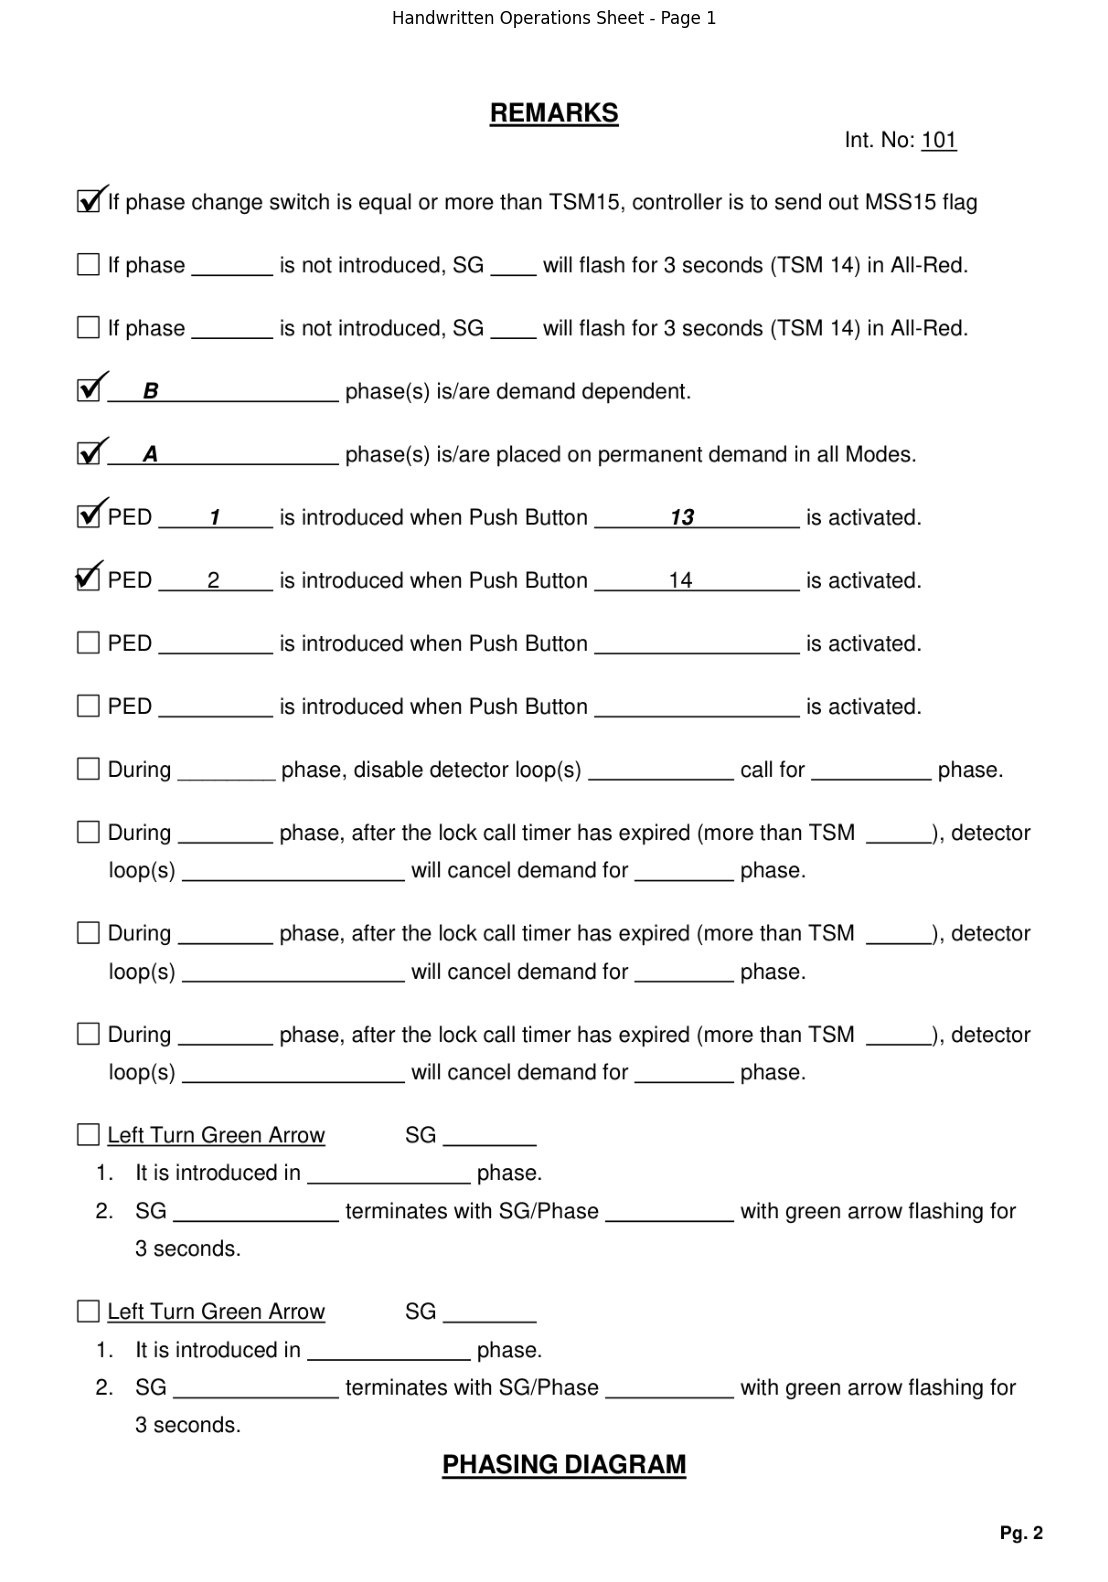

In [14]:
if ops_sheet:
    plt.figure(figsize=(15, 20))
    plt.imshow(ops_sheet[1])
    plt.axis('off')
    plt.title('Handwritten Operations Sheet - Page 1')
    plt.show()
    

image.png

In [ ]:
image.png